<br><font color='green'>
## ch.4 Libraries, Read data(1)

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


### Read Data

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

train_test = pd.concat([df_train, df_test])

## 월, 일, 요일, 계절, (월초, 월중, 월말) 칼럼 추가
train_test['month'] = train_test['tran_date'].agg(lambda x: pd.to_datetime(x).month)
train_test['day'] = train_test['tran_date'].agg(lambda x: pd.to_datetime(x).day)
train_test['date'] = train_test['tran_date'].agg(lambda x: ('월', '화', '수', '목', '금', '토', '일')[pd.to_datetime(x).weekday()])
train_test['season'] = train_test['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
train_test['month_when'] = train_test['day'].agg(lambda x: '0to10' if x in list(range(1,11)) else '11to20' if x in list(range(11,21)) else '21to31')

df_train = train_test.query('cust_id not in @IDtest')
df_test = train_test.query('cust_id in @IDtest')

### Transform Categorical Data using BOW

In [3]:
df_train

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,month,day,date,season,month_when
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,1,19,금,winter,11to20
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,3,30,금,spring,21to31
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,3,30,금,spring,21to31
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,3,30,금,spring,21to31
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,3,30,금,spring,21to31
...,...,...,...,...,...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000,12,17,월,winter,11to20
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000,12,23,일,winter,21to31
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800,12,23,일,winter,21to31
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000,12,27,목,winter,21to31


In [13]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

# 월별 방문여부
df_all = pd.concat([df_train, df_test])
train4 = pd.pivot_table(df_all, index='cust_id', columns='month', values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test4 = pd.pivot_table(df_all, index='cust_id', columns='month', values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values


# #요일별 방문여부
df_all = pd.concat([df_train, df_test])
train5 = pd.pivot_table(df_all, index='cust_id', columns='date', values='tran_date',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test5 = pd.pivot_table(df_all, index='cust_id', columns='date', values='tran_date',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values


# 계절별 방문여부
df_all = pd.concat([df_train, df_test])
train6 = pd.pivot_table(df_all, index='cust_id', columns='season', values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test6 = pd.pivot_table(df_all, index='cust_id', columns='season', values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

# 지점별 방문여부
df_all = pd.concat([df_train, df_test])
train7 = pd.pivot_table(df_all, index='cust_id', columns='store_nm', values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test7 = pd.pivot_table(df_all, index='cust_id', columns='store_nm', values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values



train = np.hstack([train1, train2, train4, train7])
test = np.hstack([test1, test2, test4, test7])


train.shape, test.shape

((3500, 416), (2482, 416))

In [14]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

train.shape, test.shape

((3500, 416), (2482, 416))

In [15]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3496,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2479,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2480,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#X_train_41 = pd.read_csv('X_train_after_preprocessing41.csv',encoding='cp949')
#X_test_41 = pd.read_csv('X_test_after_preprocessing41.csv', encoding='cp949')
#IDtest = df_test.cust_id.unique()
#y_train = pd.read_csv('y_train.csv').gender

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DNN learning curve 1/10


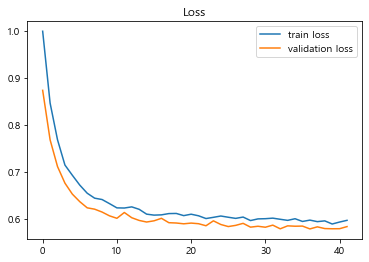

 10%|████████▎                                                                          | 1/10 [00:17<02:38, 17.58s/it]

AUC 0.7521007284891614
DNN learning curve 2/10


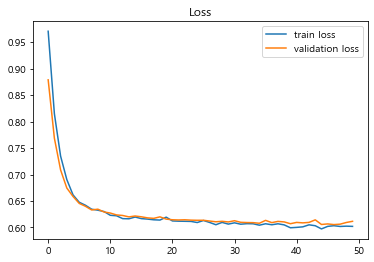

 20%|████████████████▌                                                                  | 2/10 [00:30<02:08, 16.11s/it]

AUC 0.7275049673573658
DNN learning curve 3/10


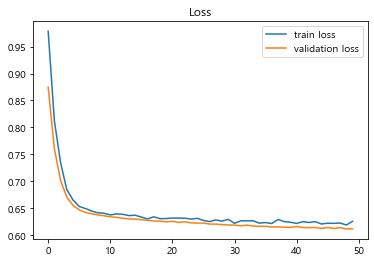

 30%|████████████████████████▉                                                          | 3/10 [00:43<01:46, 15.26s/it]

AUC 0.7347398874061719
DNN learning curve 4/10


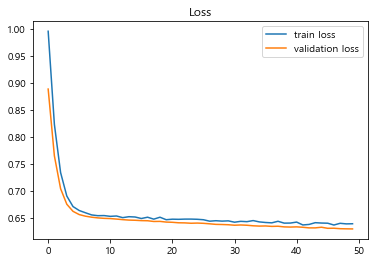

 40%|█████████████████████████████████▏                                                 | 4/10 [00:57<01:28, 14.72s/it]

AUC 0.7275507367250487
DNN learning curve 5/10


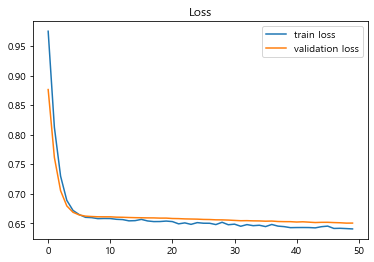

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:10<01:12, 14.43s/it]

AUC 0.6694432190708497
DNN learning curve 6/10


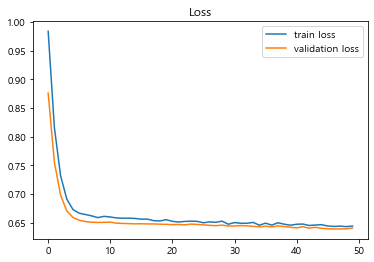

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:24<00:57, 14.32s/it]

AUC 0.6669866666666667
DNN learning curve 7/10


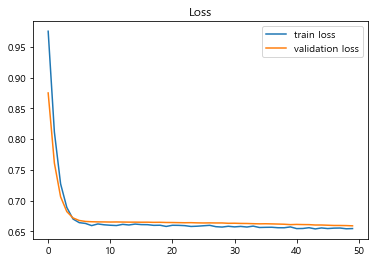

 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:39<00:43, 14.39s/it]

AUC 0.694617190927154
DNN learning curve 8/10


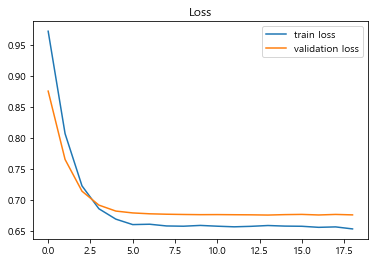

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:52<00:28, 14.15s/it]

AUC 0.6603957636566332
DNN learning curve 9/10


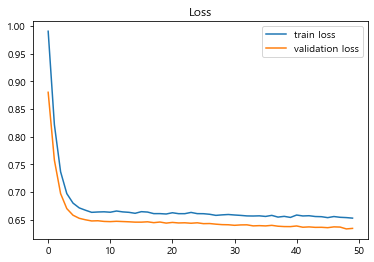

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:07<00:14, 14.35s/it]

AUC 0.7077379033702231
DNN learning curve 10/10


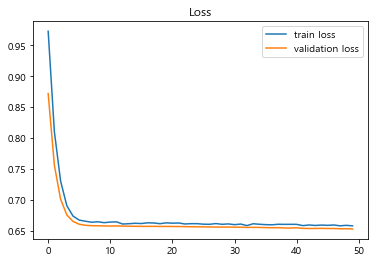

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:23<00:00, 14.35s/it]

AUC 0.6929458041958042

Validation Summary:
0    0.752101
2    0.734740
3    0.727551
1    0.727505
8    0.707738
6    0.694617
9    0.692946
4    0.669443
5    0.666987
7    0.660396
dtype: float64
mean=0.70340, std=0.032


In [19]:
X_train, X_test = train, test

# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):
    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####

    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                        shuffle=True, validation_data=(X_test,X_test), verbose=0)

#     print(f'DAE learning curve {i+1}')
#     plt.plot(history.history["loss"], label="train loss")
#     plt.plot(history.history["val_loss"], label="validation loss")
#     plt.legend()
#     plt.title("Loss")
#     plt.show()

    ##### STEP 3: Reduce Dimension #####

    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)
    
#    # < DAE 128 features + 41 percentile numbercial features >
#    X_train = pd.concat([pd.DataFrame(X_train), X_train_41], axis=1)
#    X_test = pd.concat([pd.DataFrame(X_test), X_test_41], axis=1)
    

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6))
#    model.add(Dense(32, activation='relu'))
#    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=50, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

In [10]:
# N = 15
# p = [2.56, 3.5, 4.5]
# for j in p:
#     # Power mean ensemble
#     THRESHOLD = 0.79  # Use only models whose AUC exceeds this value

#     pred = 0
#     n = 0
#     for i in range(N):
#         if aucs.iloc[i] > THRESHOLD:
#             pred = pred + preds[i]**j
#             n += 1
#     pred = pred / n    
#     pred = pred**(1/j)

#     # Make a submission file
#     t = pd.Timestamp.now()
#     fname = f"dae_p{j}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
#     submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
#     submissions.to_csv(fname, index=False)
#     print(f"'{fname}' is ready to submit.")

In [11]:
# ae_256 = pd.read_csv('dae_p2.56n5_submit_06121957.csv')
# ae_35 = pd.read_csv('dae_p3.5n5_submit_06121957.csv')
# ae_45 = pd.read_csv('dae_p4.5n5_submit_06121957.csv')

In [12]:
# ae_45.isnull().any()